In [60]:

import pandas as pd
import numpy as np # linear algebra
import glob
import os
import gc
import pickle

from joblib import Parallel, delayed

from sklearn import model_selection
import lightgbm as lgb

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
#%matplotlib inline
import plotly.express as px
from IPython.display import display
import seaborn as sns
import plotly.subplots as sub_plots
import plotly.graph_objects as go
from umap import UMAP

from scipy.stats import binned_statistic
from scipy.stats import kurtosis, skew

from numba import jit


data_dir = '/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data'

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy as sp
from sklearn.metrics import silhouette_samples,silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [61]:
# analyzed effect of log transformation on the skew and kurtosis and mean.

unique_stock_ids = np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
        74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 122, 123, 124, 125, 126])

st_skew_book_log_ask1 = []
st_skew_book_log_bid1 = []
st_kurt_book_log_ask1 = []
st_kurt_book_log_bid1 = []
st_skew_trade_log_price = []
st_kurt_trade_logprice = []

st_skew_book_ask1 = []
st_skew_book_bid1 = []
st_kurt_book_ask1 = []
st_kurt_book_bid1 = []
st_skew_trade_price = []
st_kurt_trade_price = []


for st in unique_stock_ids:
    book_data = pd.read_parquet(os.path.join(data_dir, 'book_{}.parquet/stock_id={}/'.format('train', st)))
    trade_data = pd.read_parquet(os.path.join(data_dir, 'trade_{}.parquet/stock_id={}/'.format('train', st)))
    book_data['log_bid_price1'] = book_data['bid_price1'].apply(np.log)
    book_data['log_ask_price1'] = book_data['ask_price1'].apply(np.log)
    trade_data['log_price'] = trade_data['price'].apply(np.log)

    st_skew_book_log_ask1.append(skew(book_data['log_ask_price1']))
    st_skew_book_log_bid1.append(skew(book_data['log_bid_price1']))
    st_kurt_book_log_ask1.append(kurtosis(book_data['log_ask_price1']))
    st_kurt_book_log_bid1.append(kurtosis(book_data['log_bid_price1']))
    st_skew_trade_log_price.append(skew(trade_data['log_price']))
    st_kurt_trade_logprice.append(kurtosis(trade_data['log_price']))

    st_skew_book_ask1.append(skew(book_data['ask_price1']))
    st_skew_book_bid1.append(skew(book_data['bid_price1']))
    st_kurt_book_ask1.append(kurtosis(book_data['ask_price1']))
    st_kurt_book_bid1.append(kurtosis(book_data['bid_price1']))
    st_skew_trade_price.append(skew(trade_data['price']))
    st_kurt_trade_price.append(kurtosis(trade_data['price']))
    
    # print(book_data['log_bid_price1'].describe())
    # book_data['log_bid_price1'] = book_data['bid_price1'].apply(np.log)
    # book_data.hist(column=['bid_price1','log_bid_price1'], bins=100, figsize=(20,10))

# Create subplots with 2 rows and 3 columns
fig = sub_plots.make_subplots(rows=2, cols=3)

# Add plots to the subplots
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_skew_book_ask1), row=1, col=1)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_skew_book_bid1), row=1, col=2)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_kurt_book_ask1), row=1, col=3)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_kurt_book_bid1), row=2, col=1)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_skew_trade_price), row=2, col=2)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_kurt_trade_price), row=2, col=3)
# Update x-axis and y-axis labels for each plot
fig.update_xaxes(title_text="Stock ID", row=1, col=1)
fig.update_yaxes(title_text="Skew (Book Ask1)", row=1, col=1)

fig.update_xaxes(title_text="Stock ID", row=1, col=2)
fig.update_yaxes(title_text="Skew (Book Bid1)", row=1, col=2)

fig.update_xaxes(title_text="Stock ID", row=1, col=3)
fig.update_yaxes(title_text="Kurtosis (Book Ask1)", row=1, col=3)

fig.update_xaxes(title_text="Stock ID", row=2, col=1)
fig.update_yaxes(title_text="Kurtosis (Book Bid1)", row=2, col=1)

fig.update_xaxes(title_text="Stock ID", row=2, col=2)
fig.update_yaxes(title_text="Skew (Trade Price)", row=2, col=2)

fig.update_xaxes(title_text="Stock ID", row=2, col=3)
fig.update_yaxes(title_text="Kurtosis (Trade Price)", row=2, col=3)

# Update layout
fig.update_layout(height=900, width=1600, title_text="skew and kurtosis of prices")
fig.update_traces(showlegend=True)

# Show the figure
fig.show()



# Create subplots with 2 rows and 3 columns
fig = sub_plots.make_subplots(rows=2, cols=3)

# Add plots to the subplots
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_skew_book_log_ask1), row=1, col=1)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_skew_book_log_bid1), row=1, col=2)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_kurt_book_log_ask1), row=1, col=3)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_kurt_book_log_bid1), row=2, col=1)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_skew_trade_log_price), row=2, col=2)
fig.add_trace(go.Bar(x=unique_stock_ids, y=st_kurt_trade_logprice), row=2, col=3)
# Update x-axis and y-axis labels for each plot
fig.update_xaxes(title_text="Stock ID", row=1, col=1)
fig.update_yaxes(title_text="Skew (Book Log Ask1)", row=1, col=1)

fig.update_xaxes(title_text="Stock ID", row=1, col=2)
fig.update_yaxes(title_text="Skew (Book Log Bid1)", row=1, col=2)

fig.update_xaxes(title_text="Stock ID", row=1, col=3)
fig.update_yaxes(title_text="Kurtosis (Book Log Ask1)", row=1, col=3)

fig.update_xaxes(title_text="Stock ID", row=2, col=1)
fig.update_yaxes(title_text="Kurtosis (Book Log Bid1)", row=2, col=1)

fig.update_xaxes(title_text="Stock ID", row=2, col=2)
fig.update_yaxes(title_text="Skew (Trade Log Price)", row=2, col=2)

fig.update_xaxes(title_text="Stock ID", row=2, col=3)
fig.update_yaxes(title_text="Kurtosis (Trade Log Price)", row=2, col=3)

# Update layout
fig.update_layout(height=900, width=1600, title_text="skew and kurtosis of log transformed prices")
fig.update_traces(showlegend=True)

# Show the figure
fig.show()
   




In [62]:

def find_equilibrium_price(book_data, lvl, iterations=22):
    loga2 = np.array(book_data['log_ask_price2'])
    loga1 = np.array(book_data['log_ask_price1'])
    logb1 = np.array(book_data['log_bid_price1'])
    logb2 = np.array(book_data['log_bid_price2'])
    
    asize2 = np.array(book_data['ask_size2'])
    asize1 = np.array(book_data['ask_size1'])
    bsize1 = np.array(book_data['bid_size1'])
    bsize2 = np.array(book_data['bid_size2'])
    
    ub = loga1
    lb = logb1
    
    s = (-1)**lvl
    for iter in range(iterations):
        mid_price = (ub + lb)/2.0
        inv_diff_a2 = 1.0/( 1000*( mid_price - loga2 ) )
        inv_diff_a1 = 1.0/( 1000*( mid_price - loga1 ) )
        inv_diff_b1 = 1.0/( 1000*( mid_price - logb1 ) ) # negative
        inv_diff_b2 = 1.0/( 1000*( mid_price - logb2 ) ) # negative

        f  = -(   ( bsize2*inv_diff_b2**(lvl+1) + bsize1*inv_diff_b1**(lvl+1) )
              + s*( asize1*inv_diff_a1**(lvl+1) + asize2*inv_diff_a2**(lvl+1) ) )
        
        # when lvl = even, f is positive when buy side missing volume is larger than sell side missing volume
        # when lvl = even, f is negative when sell side missing volume is larger than buy side missing volume
        # when lvl = odd, f is positive when sell side missing volume is larger than buy side missing volume and vice versa

        dub = - (ub-lb)/2.0*(f>=0)
        dlb =   (ub-lb)/2.0*(f< 0)
        
        # when f is positive, mid price moves towards buy side (bid_price) by reducing the upper bound 
        # when f is negative, mid price moves towards sell side (ask_price) by increasing the lower bound 
        ub = ub + dub
        lb = lb + dlb

    equilibrium_price = (ub + lb)/2.0    
        
    return equilibrium_price
   

In [63]:
def diff(list_stock_prices):
    return list_stock_prices.diff() 

In [64]:
@jit()
def bucketized_summed_data(seconds_arr, time_id, data, buk_width, n_buks, time_ids_size):
    z = np.zeros( (time_ids_size,n_buks) ) # 30 buckets for 600 seconds (10 minutes)

    t_id  = 0
    for s in range(seconds_arr.shape[0]): # seconds.shape[0] is total size of the seconds column i.e. total rows in seconds column
        
        if time_id[s] != time_id[max(s-1,0)]:
            t_id = t_id + 1
            
        z[t_id, int(seconds_arr[s]//buk_width)] += data[s]            
    
    return z



/tmp/ipykernel_27242/1838740033.py:1: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



In [65]:
@jit(nopython=True)
def end_bucket(buk_width, buk_sum:float, buk_weight:float, last_val, last_weight, last_time)->float: 
    dt = buk_width - last_time%buk_width
    
    buk_weight += 1.0*last_weight*dt
    buk_sum    += 1.0*last_weight*dt*last_val
    
    return float(buk_sum/(buk_weight + 1e-8))

In [66]:
@jit()
def bucketized_time_weighted_avg_data(seconds_arr, time_id_arr, data,weights, buk_width, n_buks, time_ids_size):

    z = np.zeros( (time_ids_size,n_buks) )
    
    prev_time   = 0
    prev_weight = 0.0
    prev_val    = 0.0
    
    buk_sum = 0.0
    buk_weight = 0.0

    t_id  = 0  # time id
    buk = 0  # bucket id
    for idx in range(seconds_arr.shape[0]): # seconds.shape[0] is total size of the seconds column i.e. total rows in seconds column
        
        if time_id_arr[idx] != time_id_arr[max(idx-1,0)]: # transition to new time id
            z[t_id, buk] = float(end_bucket(buk_width, buk_sum, buk_weight, prev_val, prev_weight, prev_time))
            buk += 1
            
            while buk < z.shape[1]:
                z[t_id, buk] = prev_val
                buk += 1
            t_id += 1
            buk = 0
            
            prev_time  = 0
            buk_sum    = 0.0
            buk_weight = 0.0            
            
        if int(seconds_arr[idx]//buk_width) != int(prev_time//buk_width): # transition to new bucket
            
            z[t_id, buk] = float(end_bucket(buk_width, buk_sum, buk_weight, prev_val, prev_weight, prev_time)) # end the previous bucket
            buk += 1 # move to next bucket
            
            while buk < seconds_arr[idx]//buk_width:
                z[t_id, buk] = prev_val
                buk += 1
            
            prev_time  = buk_width*(seconds_arr[idx]//buk_width)
            buk_sum    = 0.0
            buk_weight = 0.0
        
        buk_sum    += prev_val*prev_weight*(seconds_arr[idx] - prev_time)  # in the same bucket
        buk_weight +=          prev_weight*(seconds_arr[idx] - prev_time)  # in the same bucket
        
        prev_time   = seconds_arr[idx] # in the same bucket
        prev_val    = data[idx] # in the same bucket
        prev_weight = weights[idx] # in the same bucket
            
    z[t_id, buk] = end_bucket(buk_width, buk_sum, buk_weight, prev_val, prev_weight, prev_time)
    
    for buk in range(buk+1, z.shape[1]): # all buckets of the last time id
        z[t_id, buk] = prev_val
                             
    return z

/tmp/ipykernel_27242/1595728787.py:1: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



In [67]:
def create_stock_data(st_id, dset):
    
    cols = ['st_id', 'time_id', 'seconds_in_bucket']
    
    ############################## BOOK DATA ##########################################

    book_data = pd.read_parquet(os.path.join(data_dir, 'book_{}.parquet/stock_id={}/'.format(dset, st_id)))

    book_data['st_id'] = st_id
        
    columns = cols + [col for col in book_data.columns if col not in cols]
    book_data = book_data[columns]
    # columns = 'st_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2'
    
    # volume
    book_data['ask_volume1'] = book_data['ask_price1']*book_data['ask_size1']
    book_data['ask_volume2'] = book_data['ask_price2']*book_data['ask_size2']
    book_data['bid_volume1'] = book_data['bid_price1']*book_data['bid_size1']
    book_data['bid_volume2'] = book_data['bid_price2']*book_data['bid_size2']
    
    # becomes zero centered, reduces skew and kurtosis slightly bringing it slightly closer to normal for right skewed data, It is increases/worsens
    # skew and kurtosis for left-skewed data
    # correct way is to use box-cox transformation, variance stabilization
    # Most stocks are right skewed only a few are left skewed?
    book_data['log_ask_price1'] = np.log( book_data['ask_price1'] )
    book_data['log_ask_price2'] = np.log( book_data['ask_price2'] )
    book_data['log_bid_price1'] = np.log( book_data['bid_price1'] )
    book_data['log_bid_price2'] = np.log( book_data['bid_price2'] )
    
    # redefining WAP using log prices
    book_data['wap1_log_price'] = ( book_data['log_bid_price1'] * book_data['ask_size1'] + book_data['log_ask_price1'] * book_data['bid_size1'] ) / (book_data['bid_size1'] + book_data['ask_size1'])
    book_data['wap2_log_price'] = ( book_data['log_bid_price2'] * book_data['ask_size2'] + book_data['log_ask_price2'] * book_data['bid_size2'] ) / (book_data['bid_size2'] + book_data['ask_size2'])
    
    # Find equilibrium price at which trades are likely to happen
    # This price minimizes the missing total volume from buy and sell side
    book_data['wap_eqi_price0'] = find_equilibrium_price( book_data, lvl=0)
    book_data['wap_eqi_price1'] = find_equilibrium_price( book_data, lvl=1)
    book_data['wap_eqi_price2'] = find_equilibrium_price( book_data, lvl=2)
    # book_data['wap_eqi_price3'] = find_equilibrium_price( book_data, lvl=3)
    # book_data['wap_eqi_price4'] = find_equilibrium_price( book_data, lvl=4)


    # equilibrium price has converged closer to 
    book_data['liquidity0'] = (
                  book_data['bid_volume1']/( 1000*(book_data['wap_eqi_price0'] - book_data['log_bid_price1']) )
                + book_data['bid_volume2']/( 1000*(book_data['wap_eqi_price0'] - book_data['log_bid_price2']) )
                - book_data['ask_volume1']/( 1000*(book_data['wap_eqi_price0'] - book_data['log_ask_price1']) )
                - book_data['ask_volume2']/( 1000*(book_data['wap_eqi_price0'] - book_data['log_ask_price2']) )
    )    

    # liquidity 0 and liquidity 1 are negatively correlated with each other, if one has prices moving towards buy side, the other has price moving towards sell side
    book_data['liquidity1'] = (
                  book_data['bid_volume1']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_bid_price1']) )
                + book_data['bid_volume2']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_bid_price2']) )
                - book_data['ask_volume1']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_ask_price1']) )
                - book_data['ask_volume2']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_ask_price2']) )
    )    

    book_data['liquidity2'] = (
                  book_data['bid_volume1']/( 1000*(book_data['wap_eqi_price2'] - book_data['log_bid_price1']) )**2
                + book_data['bid_volume2']/( 1000*(book_data['wap_eqi_price2'] - book_data['log_bid_price2']) )**2
                + book_data['ask_volume1']/( 1000*(book_data['wap_eqi_price2'] - book_data['log_ask_price1']) )**2
                + book_data['ask_volume2']/( 1000*(book_data['wap_eqi_price2'] - book_data['log_ask_price2']) )**2
    )

    book_data['spread']     = book_data['log_ask_price1'] - book_data['log_bid_price1']
    book_data['inv_spread'] = (book_data['log_ask_price1'] - book_data['log_bid_price1'])**-2 # inverse of spread has the effect of amplifying low values and diminishing high values
    book_data['log_spread'] = book_data['spread'].apply(np.log) # log of spread has the effect of amplifying low values and diminishing high values. It can normalize right skewed data
    book_data['log_spread2'] = np.log(book_data['log_ask_price2'] - book_data['log_bid_price2'])

    book_data['book_size1'] = book_data['ask_volume1'] + book_data['bid_volume1']
    book_data['book_size'] = book_data['ask_volume1'] + book_data['bid_volume1'] + book_data['ask_volume2'] + book_data['bid_volume2'] 

    # difference betweeen ask's level 1 and level 2 liquidity
    book_data['ask_liq1_diff'] = (
                  book_data['ask_volume1']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_ask_price1']) )**1
               -  book_data['ask_volume2']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_ask_price2']) )**1
    )

    # difference betweeen bid's level 1 and level 2 liquidity
    book_data['bid_liq1_diff'] = (
                  book_data['bid_volume1']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_bid_price1']) )**1
               -  book_data['bid_volume2']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_bid_price2']) )**1
    )

    # simple returns on prices wap1_log_price,wap2_log_price,wap_eqi_price0,wap_eqi_price1
    book_data['wap1_log_price_ret' ] = book_data.groupby(by = ['time_id'])['wap1_log_price'].apply(diff).fillna(0).values
    book_data['wap2_log_price_ret' ] = book_data.groupby(by = ['time_id'])['wap2_log_price'].apply(diff).fillna(0).values
    book_data['wap_eqi_price0_ret'] = book_data.groupby(by = ['time_id'])['wap_eqi_price0'].apply(diff).fillna(0).values
    book_data['wap_eqi_price1_ret'] = book_data.groupby(by = ['time_id'])['wap_eqi_price1'].apply(diff).fillna(0).values

    # this indicates the changes in level 2 wap when level 1 wap does NOT change
    # This happens when all orders in level 1 are filled and new orders are placed in level 2
    # indication of liquidity as prices in level 2 are moving towards level 1
    # Aggressive Market Orders, Imbalance in Market Depth, Execution of Large Orders, Liquidity Changes: 
    book_data['wap2_log_price_ret_changes_n_wap1_log_price_ret_constant'] = book_data['wap2_log_price_ret' ]*(book_data['wap1_log_price_ret' ]==0)
    
    # variance stabilization of right skewed data.
    book_data['log_liquidity1'] = np.log(book_data['liquidity1'])
    book_data['log_liquidity2'] = np.log(book_data['liquidity2'])

    # simple returns on liquidity / first order changes in liquidity
    book_data['log_liquidity1_ret'] = book_data.groupby(by = ['time_id'])['log_liquidity1'].apply(diff).fillna(0).values
    book_data['log_liquidity2_ret'] = book_data.groupby(by = ['time_id'])['log_liquidity2'].apply(diff).fillna(0).values
    # simple returns on log_spread / first order changes in log_spread
    book_data['log_spread_ret'] = book_data.groupby(by = ['time_id'])['log_spread'].apply(diff).fillna(0).values

    # wap1 price returns when liquidity1 is positive/increases and negative/decreases    
    book_data['wap1_log_price_ret_pos_log_liq_ret'] = (book_data['log_liquidity1_ret']>0)*book_data['wap1_log_price_ret']
    book_data['wap1_log_price_ret_neg_log_liq_ret'] = (book_data['log_liquidity1_ret']<0)*book_data['wap1_log_price_ret']


    ids = np.array(book_data[['st_id', 'time_id']]) # single stock and all time_ids and seconda_in_bucket
    ids = np.unique(ids, axis=0)
    book_n_trade_data = {}
    book_n_trade_data['time_id'] = ids[:,1:2]
    
    # bucketized data for book data
    # Amount of wap1 price movements in a time bucket of 30 seconds, i.e. wap1 returns volatitlity in bucket
    book_n_trade_data['wap1_log_price_ret_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap1_log_price_ret']),
                                    20, 30, ids.shape[0])

    # Amount of absolute wap1 price movements in a time bucket of 30 seconds, i.e. ahsolute wap1 returns volatitlity in bucket
    book_n_trade_data['wap1_log_price_ret_abs_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.abs(np.array(book_data['wap1_log_price_ret'])),
                                    20, 30, ids.shape[0])

    # Amount of absolute wap2 price movements in a time bucket of 30 seconds, i.e.  ahsolute wap2 returns volatitlity in bucket
    book_n_trade_data['wap2_log_price_ret_abs_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.abs(np.array(book_data['wap2_log_price_ret'])),
                                    20, 30, ids.shape[0])    
    
      # wap1 returns variance/ squared volatitlity in bucket
    book_n_trade_data['wap1_log_price_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap1_log_price_ret'])**2,
                                    20, 30, ids.shape[0])
    # wap2 returns variance/ squared volatitlity in bucket
    book_n_trade_data['wap2_log_price_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap2_log_price_ret'])**2,
                                    20, 30, ids.shape[0])
    
    # squared wap1 returns volatitlity in bucket
    book_n_trade_data['wap1_log_price_ret_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap1_log_price_ret'])**2,
                                    20, 30, ids.shape[0])**0.5
    # squared wap2 returns volatitlity in bucket
    book_n_trade_data['wap2_log_price_ret_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap2_log_price_ret'])**2,
                                    20, 30, ids.shape[0])**0.5    

    # squared wap2_log_price_ret_changes_n_wap1_log_price_ret_constant volatitlity in bucket
    book_n_trade_data['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap2_log_price_ret_changes_n_wap1_log_price_ret_constant'])**2,
                                    20, 30, ids.shape[0])**0.5    
    
    # equilibrium price returns absolute volatitlity in bucket
    book_n_trade_data['wap_eqi_price0_ret_abs_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.abs(np.array(book_data['wap_eqi_price0_ret'])),
                                       20, 30, ids.shape[0])

    # squared equilibrium price returns volatitlity in bucket
    book_n_trade_data['wap_eqi_price0_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(book_data['wap_eqi_price0_ret'])**2,
                                       20, 30, ids.shape[0])**0.5
  
    # volatitlity in wap1_log_price_ret when liquidity1 return is positive. i.e. increases
    book_n_trade_data['wap1_log_price_ret_pos_log_liq_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(book_data['wap1_log_price_ret_pos_log_liq_ret'])**2,
                                       20, 30, ids.shape[0])**0.5
    # volatitlity in wap1_log_price_ret when liquidity1 is negative. i.e. decreases  
    book_n_trade_data['wap1_log_price_ret_neg_log_liq_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(book_data['wap1_log_price_ret_neg_log_liq_ret'])**2,
                                       20, 30, ids.shape[0])**0.5

    # squared wap equilibrium price 1 returns volatitlity in bucket
    book_n_trade_data['wap_eqi_price1_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(book_data['wap_eqi_price1_ret'])**2,
                                       20, 30, ids.shape[0])**0.5

    book_n_trade_data['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array((book_data['log_liquidity2_ret']*book_data['wap_eqi_price1_ret'])**2 ),
                                       20, 30, ids.shape[0])

    # squared wap equilibrium price 1 returns volatitlity in bucket amplified (> 1) by positive/increasing liquidity returns (through exponent)
    # and diminished ( < 1) by negative/decreasing liquidity returns (through exponent)
    book_n_trade_data['exp_liq1_*_wap_eqi_price1_ret_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(( np.exp(book_data['log_liquidity1_ret'])*book_data['wap_eqi_price1_ret'])**2 ),
                                       20, 30, ids.shape[0])
    # copy of above
    book_n_trade_data['exp_liq1_*_wap_eqi_price1_ret_vol_buks_2'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(( np.exp(book_data['log_liquidity1_ret'])*book_data['wap_eqi_price1_ret'])**2 ),
                                       20, 30, ids.shape[0])
    # variance/ squared volatitliy of wap1 price returns per unit of spread
    # large value indicates volatilty
    book_n_trade_data['wap1_log_price_ret_per_spread_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(( book_data['wap1_log_price_ret']/book_data['spread'])**2 ),
                                       20, 30, ids.shape[0])
    # variance/ squared volatitliy of wap1 price returns per unit of liquidity
    # small value indicates volatilty?
    book_n_trade_data['wap1_log_price_ret_per_liq2_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array( ( book_data['wap1_log_price_ret'])**2/book_data['liquidity2'] ),
                                       20, 30, ids.shape[0])

    # measure of variance/ squared volatility of liquidity1 returns
    book_n_trade_data['log_liquidity1_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(book_data['log_liquidity1_ret'])**2,
                                       20, 30, ids.shape[0])

    # measure of variance/ squared volatility of liquidity2 returns
    book_n_trade_data['log_liquidity2_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(book_data['log_liquidity2_ret'])**2,
                                       20, 30, ids.shape[0])

    # measure of variance/ squared volatility of log spread returns
    book_n_trade_data['log_spread_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                       np.array(book_data['log_spread_ret'])**2,
                                       20, 30, ids.shape[0])    

    # counting number of data points available in each time bucket
    book_n_trade_data['book_delta_count_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.array(book_data['wap1_log_price_ret']*0+1.0),
                                         20, 30, ids.shape[0])

    # time weighted average of wap1_log_price in each time bucket
    book_n_trade_data['wap1_log_price_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                                   np.array(book_data['wap1_log_price']),
                                                   np.ones((book_data.shape[0])),
                                                   20, 30, ids.shape[0])

    # time weighted average of wap2_log_price in each time bucket
    book_n_trade_data['wap2_log_price_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                                   np.array(book_data['wap2_log_price']),
                                                   np.ones((book_data.shape[0])),
                                                   20, 30, ids.shape[0])

    # time weighted average of wap_eqi_price0 equilibrium price in each time bucket
    book_n_trade_data['wap_eqi_price0_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                                   np.array(book_data['wap_eqi_price0']),
                                                   np.ones((book_data.shape[0])),
                                                   20, 30, ids.shape[0])

    # time weighted average of wap_eqi_price1 equilibrium price in each time bucket
    book_n_trade_data['wap_eqi_price1_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                                   np.array(book_data['wap_eqi_price1']),
                                                   np.ones((book_data.shape[0])),
                                                   20, 30, ids.shape[0])


    # filter out the extremely high and low prices of wap1_log_price by amplifying with postiive and negative exponential of wap1_log_price
    # apply time weighted average to the amplified wap1_log_price
    # what may be the physical meaning?
    book_n_trade_data['wap1_log_price_amp_max_wavg'] = np.log( bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                                   np.exp( 4000*np.array(book_data['wap1_log_price'])),
                                                   np.ones((book_data.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    book_n_trade_data['wap1_log_price_amp_min_wavg'] = -np.log( bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                                   np.exp(-4000*np.array(book_data['wap1_log_price'])),
                                                   np.ones((book_data.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    # amplification of the difference between max and min
    book_n_trade_data['wavg_wap1_log_price_amp_diff']  = np.exp(book_n_trade_data['wap1_log_price_amp_max_wavg'] - book_n_trade_data['wap1_log_price_amp_min_wavg'])

    # filter out the extremely high and low prices of wap_eqi_price0 by amplifying with postiive and negative exponential of wap_eqi_price0
    # apply time weighted average to the amplified wap_eqi_price0
    book_n_trade_data['wap_eqi_price0_amp_max_wavg'] = np.log( bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                                   np.exp( 4000*np.array(book_data['wap_eqi_price0'])),
                                                   np.ones((book_data.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    
    book_n_trade_data['wap_eqi_price0_amp_min_wavg'] = -np.log( bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                                   np.exp(-4000*np.array(book_data['wap_eqi_price0'])),
                                                   np.ones((book_data.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    # amplification of the difference between max and min
    book_n_trade_data['wavg_wap_eqi_price0_amp_diff']  = np.exp(book_n_trade_data['wap_eqi_price0_amp_max_wavg'] - book_n_trade_data['wap_eqi_price0_amp_min_wavg'])

    del book_n_trade_data['wap1_log_price_amp_max_wavg'], book_n_trade_data['wap1_log_price_amp_min_wavg']
    del book_n_trade_data['wap_eqi_price0_amp_max_wavg'], book_n_trade_data['wap_eqi_price0_amp_min_wavg']

    book_n_trade_data['liquidity1_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.array((book_data['liquidity1'])),
                                         np.ones((book_data.shape[0])),
                                         20, 30, ids.shape[0])

    book_n_trade_data['liquidity2_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.array((book_data['liquidity2'])),
                                         np.ones((book_data.shape[0])),
                                         20, 30, ids.shape[0])

    book_n_trade_data['root_liquidity2_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.array((book_data['liquidity2']))**0.5,
                                         np.ones((book_data.shape[0])),
                                         20, 30, ids.shape[0])

    # time weighted average of spread in each time bucket
    book_n_trade_data['spread_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.array((book_data['spread'])),
                                         np.ones((book_data.shape[0])),
                                         20, 30, ids.shape[0])
    # time weighted average of inverse spread in each time bucket
    book_n_trade_data['inv_spread_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.array((book_data['spread']))**-1,
                                         np.ones((book_data.shape[0])),
                                         20, 30, ids.shape[0])
    # time weighted average of log spread in each time bucket
    book_n_trade_data['log_spread_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.log(np.array((book_data['spread']))),
                                         np.ones((book_data.shape[0])),
                                         20, 30, ids.shape[0])
    # time weighted average of log spread 2 in each time bucket
    book_n_trade_data['log_spread2_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.array((book_data['log_spread2'])),
                                         np.ones((book_data.shape[0])),
                                         20, 30, ids.shape[0])
    # time weighted average of book size1 in each time bucket
    book_n_trade_data['book_size1_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.array((book_data['book_size1'])),
                                         np.ones((book_data.shape[0])),
                                         20, 30, ids.shape[0]) 
    # time weighted average of book size in each time bucket
    book_n_trade_data['book_size_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                       np.array(book_data['time_id']),
                                         np.array((book_data['book_size'])),
                                         np.ones((book_data.shape[0])),
                                         20, 30, ids.shape[0]) 


    ############################## TRADE DATA ##########################################

    trade_data =  pd.read_parquet(os.path.join(data_dir,'trade_{}.parquet/stock_id={}'.format( dset, st_id)))
    trade_data['trade_volume'] = trade_data['size']*trade_data['price']

    # bucketized trade volume
    book_n_trade_data['trade_volume_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                       np.array(trade_data['time_id']),
                                         np.array(trade_data['trade_volume']),
                                         20, 30, ids.shape[0])
    # bucketized root of trade volume
    book_n_trade_data['sqrt_trade_volume_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                       np.array(trade_data['time_id']),
                                         np.array(trade_data['trade_volume']**.5),
                                         20, 30, ids.shape[0])
    # bucketized cube root of trade volume
    book_n_trade_data['cube_root_volume_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                       np.array(trade_data['time_id']),
                                         np.array(trade_data['trade_volume']**(1/3)),
                                         20, 30, ids.shape[0])

    # bucketized square of cube root of trade volume
    book_n_trade_data['volume_p2/3_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                       np.array(trade_data['time_id']),
                                         np.array(trade_data['trade_volume']**(2/3)),
                                         20, 30, ids.shape[0])
    
    # bucketized quart root of trade volume
    book_n_trade_data['quart_root_volume_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                       np.array(trade_data['time_id']),
                                         np.array(trade_data['trade_volume']**.25),
                                         20, 30, ids.shape[0])
    
    # count the number of trades in each time bucket
    book_n_trade_data['trade_count_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                       np.array(trade_data['time_id']),
                                         np.array(trade_data['trade_volume']**0),
                                         20, 30, ids.shape[0])


    # trade volume per unit of liquidity1
    book_n_trade_data['trade_volume_per_liquidity1_wavg_buks'] = book_n_trade_data['trade_volume_buks']/book_n_trade_data['liquidity1_wavg']
    book_n_trade_data['trade_volume_per_liquidity2_wavg_buks'] = book_n_trade_data['trade_volume_buks']/book_n_trade_data['liquidity2_wavg']
    
    # time weighted average of difference betweeen ask's level 1 and level 2 liquidity
    book_n_trade_data['ask_liq1_diff_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                        np.array(book_data['time_id']),
                                        np.array((book_data['ask_liq1_diff'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])
    # time weighted average of difference betweeen bid's level 1 and level 2 liquidity
    book_n_trade_data['bid_liq1_diff_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                        np.array(book_data['time_id']),
                                        np.array((book_data['bid_liq1_diff'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])
    
    return book_n_trade_data


In [68]:
@jit()
def identify_missing_time_ids(all_time_ids, st_time_ids): # all_time_ids is all unique time_ids from all stocks, st_time_ids is time_ids for particular single stock
    j = 0
    z = 1 == np.zeros(  all_time_ids.shape[0]) # set all unique time_ids to False
    for i in range(st_time_ids.shape[0]):
        while all_time_ids[j] != st_time_ids[i]: # missing time id in the stock
            z[j] = False # set the missing time id index in all unique time ids array z to False
            j = j+1
            if j >= all_time_ids.shape[0]:
                return z
        z[j] = True
        j = j+1
    return z

/tmp/ipykernel_27242/2718139284.py:1: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



# BUCKETIZE RAW DATA 
##### BUCKETIZING IRREGULARLY SPACED DATA WITHIN FIRST 10 MINS FOR EACH STOCK TO MAKE THEM COMPARABLE ACROSS STOCKS. CREATE GRANULARITY WITHIN 10 FIRST MINS. This is a way to standardize data arriving at irreguar seconds 

In [69]:
def create_dataSet(st_ids,dset):
    
    st_ids = sorted(st_ids)
    
    print('st_ids',st_ids)

    # a list contains all stock data each element of list is a dictionary of features for a particular stock
    all_stock_data = Parallel(n_jobs = os.cpu_count() - 5)( delayed(create_stock_data)(st_id, dset) for st_id in st_ids)

    final_data = {}
    
    # get all unique time ids from all stocks. This is helpful to fill missing time ids.
    t_ids = sum([list(ss['time_id']) for ss in all_stock_data], [] )
    t_ids = list(np.unique(t_ids))
    
    num_buks = 30
    t_ids_size = len(t_ids)
    st_ids_size = len(st_ids)
    
    final_data['time_ids' ] = np.array(t_ids)
    final_data['stock_ids'] = np.array(st_ids)
    

    for key in all_stock_data[0].keys(): # common columns (features) to all stocks
        if key == 'time_id':
            continue
        
        Z = np.zeros(( t_ids_size, st_ids_size, num_buks))
        
        for st in range(st_ids_size):
            ss = all_stock_data[st]

            #ts = index_into_set(np.array(time_ids), ss['time_id']).astype(int)

            b = identify_missing_time_ids(np.array(t_ids), ss['time_id']) # all unique time ids from all stocks and time ids of a particular stock are input

            #print(b)
            #print(b.shape)
            
            Z[ b, st, :] = ss[key] # fill with features for avaialble time ids
            
            Z[~b, st, :] = np.nanmean(ss[key]) # fill with mean of features for missing time ids
            
            Z[:,st,:][np.isnan(Z[:,st,:])] = np.nanmean(Z[:,st,:]) # fill with mean of features for missing time ids and any missing bins
                                              
            #del ss[key]
        
        final_data[key] = Z
        
        gc.collect()
        
        
    del all_stock_data
    gc.collect()
    

    # arbitrarily weighted average of wap1_log_price_ret_abs_vol_buks and wap2_log_price_ret_abs_vol_buks
    final_data['wap1_log_price_ret_vol_buks'] = ( final_data['wap1_log_price_ret_vol_buks']**2 + .25*final_data['wap2_log_price_ret_vol_buks']**2)**0.5

    return final_data    

In [70]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/liquidity_features')

# train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
# train_buckets = create_dataSet(st_ids = list(np.unique(train['stock_id'])), dset = 'train')
# with open('train_buckets.pkl', 'wb') as fp:
#     pickle.dump(train_buckets, fp)
#     print('saved train_buckets.pkl successfully')

with open('train_buckets.pkl', 'rb') as fp:
    train_buckets = pickle.load(fp)
    print('train_buckets.pkl file')
train_buckets # shape of (time_id=3830,stock_id= 112, bins=30)

st_ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126]


/tmp/ipykernel_27242/1530168138.py:290: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_27242/1530168138.py:290: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_27242/1530168138.py:288: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_27242/1530168138.py:288: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_27242/1530168138.py:296: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_27242/1530168138.py:296: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_27242/1530168138.py:294: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_27242/1530168138.py:300: RuntimeWarning: invalid value encountered in subtract
/tmp/ipykernel_27242/1530168138.py:294: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_27242/1530168138.py:300: RuntimeWarning: invalid value encountered in subtract
/tmp/ipykernel_27242/1530168138.py:275: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_27242/1530168138.

saved train_buckets.pkl successfully
train_buckets.pkl file


{'time_ids': array([    5,    11,    16, ..., 32758, 32763, 32767]),
 'stock_ids': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
         59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
         74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        118, 119, 120, 122, 123, 124, 125, 126]),
 'wap1_log_price_ret_buks': array([[[ 8.91169751e-06,  1.08527344e-03,  1.09018885e-03, ...,
          -1.53106429e-03,  1.34976375e-03,  3.23275359e-04],
         [ 6.74908282e-04,  1.31428824e-03,  1.29922992e-04, ...,
          -4.63231234e-04,  7.52710039e-04, -1.62483193e-04],
 

# CLUSTERING ANALYSIS

In [71]:
# ## Dimensionality reduction by UMAP 3D
def plot_UMAP_3d(X_feat,n_neighbors,min_dist,metric):
    umap_3d = UMAP(n_components=3,n_neighbors=n_neighbors,min_dist=min_dist,metric=metric, init='random', random_state=0)
    proj_3d = umap_3d.fit_transform(X_feat)
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=proj_3d[:, 0],
        y=proj_3d[:, 1],
        z=proj_3d[:, 2],
        mode='markers',marker=dict(size=5,
        color=np.arange(len(X_feat)),
        colorscale='Viridis',showscale=True),))
    
    fig.update_layout(height=500 , width=500,title='UMAP 3D projection of stock_ids principal components')
    fig.show()
    return

In [73]:
# ## Dimensionality reduction by UMAP 2D
def plot_UMAP_2d(X_feat,n_neighbors,min_dist,metric):
    umap_2d = UMAP(n_components=2,n_neighbors=n_neighbors,min_dist=min_dist,metric=metric, init='random', random_state=0)
    proj_2d = umap_2d.fit_transform(X_feat)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=proj_2d[:, 0],
        y=proj_2d[:, 1],
        mode='markers',marker=dict(size=5,
        color=np.arange(len(X_feat)),
        colorscale='Viridis',showscale=True),))
    
    fig.update_layout(height=500 , width=500,title='UMAP 2D projection of stock_ids principal components')
    fig.show()
    return

In [74]:
def plot_first_3_pcs(scaled_pcs):
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=scaled_pcs[:, 0],  # X-axis values from the low-dimensional representation
        y=scaled_pcs[:, 1],  # Y-axis values from the low-dimensional representation
        z=scaled_pcs[:, 2],  # Z-axis values from the low-dimensional representation
        mode='markers',
        marker=dict(
            size=5,
            color=np.arange(len(scaled_pcs)),  # Color points based on a range of values (e.g., sample index)
            colorscale='Viridis',  # Choose a colorscale
            showscale=True  # Show the colorbar
        ),name="first 3 PCs",
    ))
    fig.update_layout(height=500 , width=500,title='First 3 PCs')
    fig.show()
    return

In [75]:
## verify the clustering using silhouette score for particular clustring parameters
def plot_silhouette_scores(X_train,labels,metric,linkage,clustering_type):
    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)
    sample_silhouette_values = silhouette_samples(X=X_train, labels=labels,metric=metric)
    silhouette_avg = silhouette_score(X=X_train, labels=labels,metric=metric)
    fig, ax1 = plt.subplots()
    y_lower = 10
    mean_num_zones_dev_in_clusters = []

    mean_num_zones_in_clusters = X_train.shape[0] /num_clusters

    for i in range(num_clusters): # exclude the
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / num_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        mean_num_zones_dev_in_clusters.append(abs(mean_num_zones_in_clusters - np.sum(labels == i) ))

    ax1.set_title("metric: "+metric+", linkage: "+linkage+", silhouette_avg: "+str(silhouette_avg)+", num_clusters: "+str(num_clusters)+", Cluster_type : "+clustering_type )
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    num_neg_silhouette_scores = np.sum(sample_silhouette_values < 0 )
    min_silhouette_score = min(sample_silhouette_values)
    dev_from_mean_num_zone = np.sum(np.array(mean_num_zones_dev_in_clusters))
    return silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone

In [76]:
def perform_hierarchical_clustering(feat):

    #['single','complete','average','weighted','centroid','median','ward']
    clustering_type = 'Agg. Hier. Clustering'
    metrics = ['euclidean'] # ['cityblock', 'mahalanobis']
    Best_silhouette_parameters = {}
    for metric in metrics:
        for method in ['ward']:
            Z = linkage(y=feat, method=method, metric=metric, optimal_ordering=True)

            for t in np.arange(14.5,15,0.5): # SET depth of dendrogram to select number of clusters 
                # Calculate the cluster
                labels = fcluster(Z, t, criterion='distance')
                # Keep the indices to sort labels
                labels_order = np.argsort(labels)

                plt.figure(figsize=(20,5))
                plt.title("Method: {}, threshold: {}".format(method,t))
                dendrogram(Z,color_threshold=t)
                plt.show()

                silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(feat,labels,'euclidean',method,clustering_type)
                Best_silhouette_parameters[silhouette_avg] = [labels,metric,method,t,num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone] 

    max_silhouette_avg = max(Best_silhouette_parameters.keys())
    print(f'Best silhouette score: {max_silhouette_avg} ,Best_silhouette_parameters: {Best_silhouette_parameters[max_silhouette_avg]}')
    return Best_silhouette_parameters[max_silhouette_avg][0] # return labels 

In [77]:
def perform_clustering(feature,num_clusters=2): # a particular feature for all stocks

    # replace nan with mean
    feature[~np.isfinite(feature)] = np.mean(feature[np.isfinite(feature)]) # feature shape of (time_id=3830,stock_id= 112)

    # feature standardization along time_id axis
    feature = feature - np.nanmean(feature, 0)
    feature = feature / (np.nanstd(feature, 0)+1e-20)
    
    # correlation coefficient between stocks, C.shape = 112x112
    Corr = np.corrcoef(feature.T)
    # fisher z transformation, it normalizes the distirution of C, make it more symmetric and stabilize the variance as correlation is bounded by [-1,1]
    # After arctanh the values are unbounded 
    Corr = np.arctanh(Corr)

    # set diagonal self-correlation elements to zero
    a = np.arange(Corr.shape[0])
    Corr[a,a] = 0

    # mean centering     
    m = np.mean(Corr, 1, keepdims=True)
    Corr = Corr - (m + m.T)
    # set diagonal self-correlation elements to mean of all correlations
    Corr[a,a] = np.mean(Corr)

    # perform pca over time_id axis
    pca = PCA(feature.shape[1]) # 112 components, each component has 112 loadings (represnting stock ids)
    pca.fit(feature)
    # singular values (eigenvalues) represent the variance contribution of each component or the true rank of the matrix
    # when singular values are close to zero, the corresponding components can be ignored so we multiply the components with singular values
    scaled_pcs = pca.components_ * pca.singular_values_[:,np.newaxis]**.5
    
    # Transpose, i.e. dimension of scaled_pcs is now stock ids x principal components.
    # each row represents a stock and its entry is a contribution from each of the principal components
    scaled_pcs = scaled_pcs.T
    
    # Visualize the first 3 principal components of the scaled_pcs to select the clustering algorithm
    plot_first_3_pcs(scaled_pcs)

    # compare the visualization of first 3 principal components of the scaled_pcs with the dim. reduced UMAP of scaled_pcs matrix
    # 1) visualize the scaled_pcs vector distribution in low dim. space in order to choose approapriate clustering algorithm
    # lower dim. distribution of summary stats. vector is representative of the original high dim. distribution
    ### static UMAP
    plot_UMAP_3d(scaled_pcs,40,0.9,'euclidean')

    # do not normalize the PCs because each component explains different amount of variance. 
    # IF we normalize and bring it to same scale, we will lose the variance information between components
    intial_labels = perform_hierarchical_clustering(scaled_pcs)
    
    # find mean principal component for each cluster
    cluster_mean_pcs = []    
    for k in range(np.max(intial_labels)):
        mean = np.mean(scaled_pcs[intial_labels==k+1, :], 0) # labels start from 1 so k+1
        cluster_mean_pcs.append(mean)
    cluster_mean_pcs= np.vstack(cluster_mean_pcs)    

    # check if GMM is suitable for clustering
    plot_UMAP_2d(scaled_pcs,40,0.9,'euclidean')

    gm = GaussianMixture(cluster_mean_pcs.shape[0], means_init=cluster_mean_pcs, weights_init=np.ones(cluster_mean_pcs.shape[0])/cluster_mean_pcs.shape[0], covariance_type='full', 
                         precisions_init=np.repeat( np.eye(cluster_mean_pcs.shape[1])[np.newaxis,:,:]/cluster_mean_pcs.shape[1], repeats=cluster_mean_pcs.shape[0], axis=0) )
                             
    new_labels = gm.fit_predict(scaled_pcs)
    

    print('new_labels',new_labels)    
    _, counts = np.unique( new_labels, return_counts=True)
    print('label counts',counts)

    # compute clustering score
    score=0
    num_clusters= np.max(new_labels)+1
    for c in range(num_clusters):
        Q =  Corr[new_labels==c,:][:,new_labels==c]
        # mean of z transformed correlation coefficients belonging to a cluster
        score += np.mean(Q)/num_clusters # score is clustering density, sum of mean correlation per cluster over all clusters
        # this can also help to find the correct number of clusters
    print('SCORE', score)
    
    # group stocks by cluster from smallest to largest labels
    l = np.argsort(new_labels)
    
    # display the correlation values of stocks in each cluster next to each other
    plt.imshow( (Corr[l,:][:,l]) )
    plt.show()

    return new_labels




In [78]:
def find_high_correlation_stocks(feature, cutoff_percentile):  

    # a particular feature for all stocks
    # replace nan with mean
    #  # feature shape of (time_id=3830,stock_id= 112)

    feature[~np.isfinite(feature)] = np.mean(feature[np.isfinite(feature)])

    # feature standardization along time_id axis
    feature = feature - np.nanmean(feature, 0)
    feature = feature / np.nanstd(feature, 0)

    # correlation coefficient between stocks, C.shape = 112x112    
    Corr = np.corrcoef(feature.T)
    # select the median correlation coefficient of each stock
    median = np.median(Corr, 1)
    
    # mask of stocks with median correlation coefficient above cutoff percentile
    b = median > np.quantile(median,cutoff_percentile)
    
    # select the indexes of stocks in the feature matrix > cutoff percentile (NOT stock ids)
    indices =  np.arange(median.shape[0])[b]

    return indices

/tmp/ipykernel_27242/2449934076.py:14: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_27242/2449934076.py:16: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_27242/2449934076.py:19: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_27242/977576747.py:14: RuntimeWarning:

divide by zero encountered in arctanh



/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



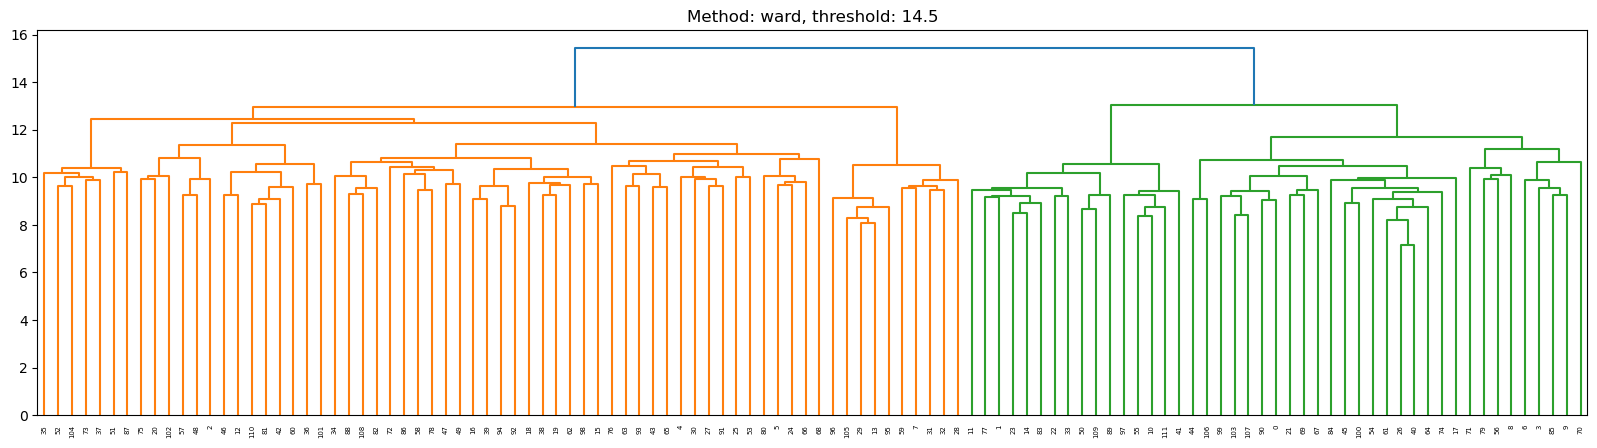

Best silhouette score: 0.00953263464670944 ,Best_silhouette_parameters: [array([2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2,
       1, 2], dtype=int32), 'euclidean', 'ward', 14.5, 54, -0.027260090517001876, 67.0]


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



new_labels [1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0
 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0
 1]
label counts [65 47]
SCORE -0.24547593948266633


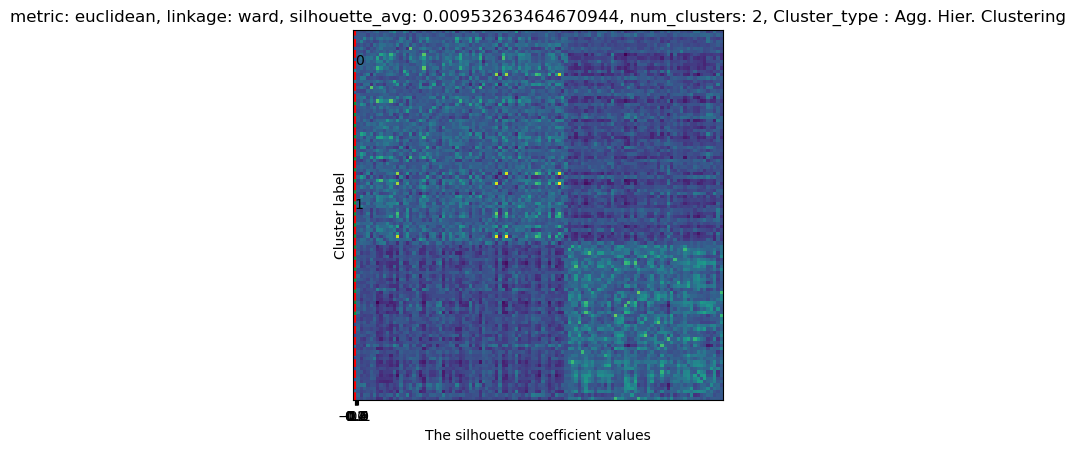

In [79]:

sqrt_trade_volume_buks   = train_buckets['sqrt_trade_volume_buks']
trade_volume_buks    = train_buckets['trade_volume_buks']
wap1_log_price_ret_vol_buks   = train_buckets['wap1_log_price_ret_vol_buks']
wap1_log_price_ret_buks   = train_buckets['wap1_log_price_ret_buks']
log_spread_wavg  = train_buckets['log_spread_wavg']
liquidity1_wavg  = train_buckets['liquidity1_wavg']
liquidity2_wavg   = train_buckets['liquidity2_wavg']

# average out along the buckets axis
wap1_log_price_ret = np.mean(wap1_log_price_ret_buks,2)

wap1_log_price_ret_vol = np.mean(wap1_log_price_ret_vol_buks**2, 2)**.5
# how much trade volume is there per unit of liquidity1
log_trade_volume_per_liquidity1 = np.log(np.mean( sqrt_trade_volume_buks, 2)/np.mean( liquidity1_wavg, 2))
# quadratic root helps to shrink the large values and reduce right skewness
log_quart_trade_volume = np.log(np.mean(sqrt_trade_volume_buks**.5,2))
log_spread = (np.mean(log_spread_wavg,2))
# log helps to reduce right skewness 
log_wap1_log_price_ret_vol = np.log(wap1_log_price_ret_vol_buks)
trade_volume = (np.mean(trade_volume_buks,2) )


wap1_log_price_ret_cluster1 = perform_clustering(wap1_log_price_ret, num_clusters=2)
wap1_log_price_ret_cluster2 = perform_clustering(wap1_log_price_ret, num_clusters=3)
wap1_log_price_ret_cluster3 = perform_clustering(wap1_log_price_ret, num_clusters=4)
wap1_log_price_ret_cluster4 = perform_clustering(wap1_log_price_ret, num_clusters=5)
wap1_log_price_ret_cluster5 = perform_clustering(wap1_log_price_ret, num_clusters=6) 

# select the percentile in order to set the threshold for correlation coefficient
# use percentile when its difficult to set the threshold at a particular value
wap1_log_price_ret_high_corr_stocks = find_high_correlation_stocks(wap1_log_price_ret, .9) 

log_wap1_log_price_ret_vol_clusters1 = perform_clustering(log_wap1_log_price_ret_vol, num_clusters=2)
log_wap1_log_price_ret_vol_clusters2 = perform_clustering(log_wap1_log_price_ret_vol, num_clusters=3)
log_wap1_log_price_ret_vol_clusters3 = perform_clustering(log_wap1_log_price_ret_vol, num_clusters=4)
log_wap1_log_price_ret_vol_clusters4 = perform_clustering(log_wap1_log_price_ret_vol, num_clusters=5) 

log_wap1_log_price_ret_vol_high_corr_stocks = find_high_correlation_stocks(log_wap1_log_price_ret_vol, .9) 


log_quart_trade_volume_clusters1 = perform_clustering(log_quart_trade_volume, num_clusters=2)
log_quart_trade_volume_clusters2 = perform_clustering(log_quart_trade_volume, num_clusters=3)
log_quart_trade_volume_clusters3 = perform_clustering(log_quart_trade_volume, num_clusters=4)
log_quart_trade_volume_clusters4 = perform_clustering(log_quart_trade_volume, num_clusters=5)

del sqrt_trade_volume_buks, trade_volume_buks, wap1_log_price_ret_vol_buks, wap1_log_price_ret_buks, log_spread_wavg, liquidity1_wavg  
del wap1_log_price_ret, wap1_log_price_ret_vol, log_trade_volume_per_liquidity1, log_quart_trade_volume, log_wap1_log_price_ret_vol, trade_volume

# FEATURE ENGINEERING

In [103]:
def get_cohesion_features(train_buckets, final_features, ffrom=0):
    wap1_log_price_ret_buks = train_buckets['wap1_log_price_ret_buks'] # shape of (3830,112,30)

    if ffrom > 0:
        suffix = f'_from_{ffrom}'
    else:
        suffix = ''
    
    # variance along time_id axis, mean along bucket axis and then square root
    # basically standard deviation of wap1_log_price_ret_buks in each stock. This is like (overall) volatility over entire time period for each stock.
    stocks_overall_wap1_log_price_ret_vol = np.mean( np.var(wap1_log_price_ret_buks, 0,keepdims=True), 2, keepdims=True)**0.5 # shape of (1,112,1)

    # normalize the variance of wap1_log_price_ret_buks by overall volatility, assume that mean of wap1_log_price_ret_buks is zero
    wap1_log_price_ret_normalized = wap1_log_price_ret_buks[:,:,ffrom:]/stocks_overall_wap1_log_price_ret_vol # shape of (3830,112,30)
    
    # variance of wap1_log_price_ret_normalized along stock id axis, mean along bucket axis and then square root, shape of (3830,1,1) and then normalized by wap1_log_price_ret_vol (shape 3830 x 112, 1). dim 1 is broadcasted to dim 112 
    # multiply by stocks_overall_wap1_log_price_ret_vol (shape = (1,112,1) ) to get the original variance of wap1_log_price_ret_buks to get final shape of (3830,112,1)
    # multiplication by stocks_overall_wap1_log_price_ret_vol (overall volatility) is the reverse of normalization
    final_features['tbin_var'               + suffix] = stocks_overall_wap1_log_price_ret_vol*np.mean(  np.var( wap1_log_price_ret_normalized, 1, keepdims=True)         , 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol']
    # shape of (3830,112,1), 
    final_features['market_var'             + suffix] = stocks_overall_wap1_log_price_ret_vol*np.mean( (np.mean(wap1_log_price_ret_normalized, 1, keepdims=True)     )**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol']
    # shape of (3830,112,1), market is np.mean(wap1_log_price_ret_normalized, 1, keepdims=True). IT is just mean over all stock ids.  
    # deviation from market is np.mean(wap1_log_price_ret_normalized, 1, keepdims=True)  minus wap1_log_price_ret_normalized
    final_features['deviations_from_market' + suffix] = stocks_overall_wap1_log_price_ret_vol*np.mean( (np.mean(wap1_log_price_ret_normalized, 1, keepdims=True) - wap1_log_price_ret_normalized)**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol']





In [ ]:
def cluster_agg(x, clusters, agg_fun):
    r = 0*x
    
    for k in range(np.max(clusters)+1):
        z = agg_fun(x[:,clusters==k,:], 1, keepdims=True) # all stocks in a cluster are aggregated along stock_id axis
        r[:,clusters==k,:] = np.repeat(z, repeats=int(np.sum(clusters==k)), axis=1) # repeat the aggregated value for each stock in the cluster
    return r

In [ ]:
def get_misc_features(train_buckets, final_features):
    
    trade_volume_buks    = train_buckets['trade_volume_buks']
    wap1_log_price_ret_vol_buks    = train_buckets['wap1_log_price_ret_vol_buks']
    sqrt_trade_volume_buks   = train_buckets['sqrt_trade_volume_buks']
    liquidity2_wavg   = train_buckets['liquidity2_wavg']
    log_spread2_wavg  = train_buckets['log_spread2_wavg']

    # average out along the time ids and buckets axis
    stocks_overall_trade_volume  = np.nanmean( trade_volume_buks, (0,2), keepdims=True) # shape of (1,112,1)
    stocks_overall_sqrt_trade_volume = np.nanmean(sqrt_trade_volume_buks, (0,2), keepdims=True) # shape of (1,112,1)
    stocks_overall_liquidity2 = np.nanmean(liquidity2_wavg, (0,2), keepdims=True) # shape of (1,112,1)
    # average out along the buckets axis
    stocks_overall_wap1_log_price_ret_vol = np.nanmean(wap1_log_price_ret_vol_buks**2, 2, keepdims=True)**.5 # shape of (3830,112,1)

    # (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)  = (vol[:,:, 0:] / s ) / (liq2[:,:, 0:]) / l2), standardized volume divided by standardized liquidity2
    # (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8) , diminish the effect of outliers, or reduce large values
    # np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True) , average over stock_id and buckets axis
    # (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True)**8) , destandardize and then take the power of 8 to undo the effect of 1/8
    # (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5 , take the square root as it is liquidity of level 2 
    # (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1 , divide by wap1_log_price_ret_vol to check > 1
    # for greater than wap1_log_price_ret_vol or wap1_log_price_ret_vol < 1 for less than wap1_log_price_ret_vol
    # log detects > 1 or < 1
    final_features['soft_stock_mean_tvpl2'    ] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:, 0:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)
    # using only the last 20 buckets
    final_features['soft_stock_mean_tvpl2_f10'] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:,10:]/liquidity2_wavg[:,:,10:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)
    # using only the last 10 buckets
    final_features['soft_stock_mean_tvpl2_f20'] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:,20:]/liquidity2_wavg[:,:,20:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)

    # same as above but only using the last bucket of liquidity2   
    final_features['soft_stock_mean_tvpl2_liqf'       ] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:,-1:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)
    final_features['soft_stock_mean_tvpl2_liqf_volf10'] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:,10:]/liquidity2_wavg[:,:,-1:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)
    final_features['soft_stock_mean_tvpl2_liqf_volf20'] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:,20:]/liquidity2_wavg[:,:,-1:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)
    
    # np.mean(vol1[:,:,25:]**2,2,keepdims=True) ,squared wap1_log_price_ret_vol_buks average for last 5 buckets
    # np.mean(vol1[:,:,:15]**2,2,keepdims=True) , squared wap1_log_price_ret_vol_buks average for first 15 buckets
    # np.nanmedian( np.mean(vol1[:,:,25:]**2,2,keepdims=True) / np.mean(vol1[:,:,:15]**2,2,keepdims=True),1,keepdims=True) , median of ratio  along stock_id axis , shape of (3830,1,1)
    # square root to get back standard deviation / volatility
    # log to detect > 1 or < 1
    final_features['v1proj_25_15'] = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True) / np.mean(wap1_log_price_ret_vol_buks[:,:,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    # same as above but only for wap1_log_price_ret high correlation stocks
    final_features['v1proj_25_15_lr1_high_corr_stocks'] = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,wap1_log_price_ret_high_corr_stocks,25:]**2,2,keepdims=True)
                                                                / np.mean(wap1_log_price_ret_vol_buks[:,wap1_log_price_ret_high_corr_stocks,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
    # same as above but only for wap1_log_price_ret_vol high correlation stocks
    final_features['v1proj_25_15_vol1_high_corr_stocks'] = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,log_wap1_log_price_ret_vol_high_corr_stocks,25:]**2,2,keepdims=True)
                                                                 / np.mean(wap1_log_price_ret_vol_buks[:,log_wap1_log_price_ret_vol_high_corr_stocks,:15]**2,2,keepdims=True),1,keepdims=True)**.5 ) 
    # same as above but ratio of average of last 5 buckets to average of all buckets
    final_features['v1proj_25_lr1_high_corr_stocks']     = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,wap1_log_price_ret_high_corr_stocks,25:]**2,2,keepdims=True)
                                                             / np.mean(wap1_log_price_ret_vol_buks[:,wap1_log_price_ret_high_corr_stocks,:]**2,2,keepdims=True),1,keepdims=True)**.5 )
    # same as above but ratio of average of last 5 buckets to average of all buckets
    final_features['v1proj_25_vol1_high_corr_stocks']    = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,log_wap1_log_price_ret_vol_high_corr_stocks,25:]**2,2,keepdims=True)
                                                              / np.mean(wap1_log_price_ret_vol_buks[:,log_wap1_log_price_ret_vol_high_corr_stocks,:]**2,2,keepdims=True),1,keepdims=True)**.5 )

    # average of log_spread_ret_sqr_vol_buks over all buckets
    final_features['lsvol'] = np.log( np.nanmean(train_buckets['log_spread_ret_sqr_vol_buks'], 2, keepdims=True))    


    # average of log_liquidity1_ret_sqr_vol_buks over all buckets
    final_features['liqvol1'] = np.log( np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'], 2, keepdims=True))    
    # average of log_liquidity2_ret_sqr_vol_buks over all stock ids and buckets
    final_features['liqvol1_smean'] = np.log( np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'], (1,2), keepdims=True)) # shape of (3830,1,1) 

    # average of log_liquidity1_ret_sqr_vol_buks over all buckets for each cluster
    # is grouped by cluster and then median is taken. repeat the median value for each stock in the same cluster. shape of (3830,112,1)
    final_features['liqvol1_smean_c3'] = np.log( cluster_agg(np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'], 2, keepdims=True), wap1_log_price_ret_cluster3 ,np.nanmedian))    

    # average of log_liquidity2_ret_sqr_vol_buks over all buckets
    final_features['liqvol2'] = np.log( np.nanmean(train_buckets['log_liquidity2_ret_sqr_vol_buks'], 2, keepdims=True))    
 
    # ratio of average log_liquidity1_ret_sqr_vol_buks in last 15 buckets to first 15 buckets
    final_features['liqvol1_15_15'] = np.log( np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'][:,:,15:  ], 2, keepdims=True)
                                            /np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'][:,:,  :15], 2, keepdims=True))    
    
    # average of trade_count over all buckets
    final_features['trade_count']      = np.log( np.nanmean(train_buckets['trade_count']    , 2, keepdims=True))    
    # average of squre root of trade_count over all buckets 
    final_features['root_trade_count'] = np.log( np.nanmean(train_buckets['trade_count']**.5, 2, keepdims=True))    

    # average of squre root of trade_count over all stock ids and all buckets  
    final_features['root_trade_count_smean'] = np.log( np.nanmean(train_buckets['trade_count']**.5, (1,2), keepdims=True))        

    # average of squre root of number of data points in a bucket over all buckets
    final_features['root_book_delta_count'] = np.log( np.nanmean(train_buckets['book_delta_count_buks']**.5, 2, keepdims=True))    

    # average of square root of trade_count over all buckets for each cluster
    # is grouped by cluster 1 and then mean is taken. repeat the mean value for each stock in the same cluster. shape of (3830,112,1) 
    final_features['root_trade_count_smean_c1'] = np.log( cluster_agg(np.nanmean(train_buckets['trade_count']**0.5, 2, keepdims=True),
                                                                     wap1_log_price_ret_cluster1,np.nanmean))

    # average of square root of trade_count over all buckets for each cluster
    # is grouped by cluster 2 and then mean is taken. repeat the mean value for each stock in the same cluster. shape of (3830,112,1)    
    final_features['root_trade_count_smean_c2'] = np.log( cluster_agg(np.nanmean(train_buckets['trade_count']**0.5, 2, keepdims=True),
                                                                     wap1_log_price_ret_cluster2,np.nanmean))
    
    # average of square root of trade_count over all buckets for each cluster
    # is grouped by cluster 3 and then mean is taken. repeat the mean value for each stock in the same cluster. shape of (3830,112,1)
    final_features['root_trade_count_smean_c3'] = np.log( cluster_agg(np.nanmean(train_buckets['trade_count']**0.5, 2, keepdims=True),
                                                                     wap1_log_price_ret_cluster3,np.nanmean))    
    
    # variance of square root of trade_count over all buckets for each cluster    
    final_features['root_trade_count_var'] = np.log( np.nanvar(train_buckets['trade_count']**.5, 2, keepdims=True))   

    # ratio of average trade_count in last 15 buckets to first 15 buckets
    final_features['trade_count_15_15']      = np.log( np.nanmean(train_buckets['trade_count'][:,:,15:  ], 2, keepdims=True)/
                                                      np.nanmean(train_buckets['trade_count'][:,:,  :15], 2, keepdims=True))

    # ratio of average square root trade_count in last 15 buckets to first 15 buckets                                                          
    final_features['root_trade_count_15_15'] =  np.log( np.nanmean(train_buckets['trade_count'][:,:,15:  ]**.5, 2, keepdims=True)/
                                                       np.nanmean(train_buckets['trade_count'][:,:,  :15]**.5, 2, keepdims=True)) 
    
    # median of ratio of mean wap1_log_price_ret_vol_buks in last bucket to first 15 buckets along stock_id axis, shape of (3830,1,1)                                                           
    final_features['v1proj_29_15'] = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,29:  ]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True),1,keepdims=True)**.5)
    
    # median of ratio of mean wap1_log_price_ret_vol_buks in last 10 buckets to all buckets along stock_id axis, shape of (3830,1,1)     
    final_features['v1proj_20']    = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,20:  ]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 ) 
    
    # median of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to all buckets along stock_id axis, shape of (3830,1,1)        
    final_features['v1proj_25']    = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,25:  ]**2,2,keepdims=True) 
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )

    # median of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1)   
    final_features['v1proj_29']    = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,28:  ]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )

    # 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1)       
    final_features['v1proj_29_q1'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    
    # 75% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1)     
    final_features['v1proj_29_q3'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    
    # 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to all buckets along stock_id axis, shape of (3830,1,1)    
    final_features['v1proj_25_q1'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )

    # 75% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to all buckets along stock_id axis, shape of (3830,1,1)    
    final_features['v1proj_25_q3'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 ) 
    
    # 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)    
    final_features['v1proj_29_15_q1'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )

    # 75% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)    
    final_features['v1proj_29_15_q3'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    
    # 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)        
    final_features['v1proj_25_15_q1'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )

    # 75% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)        
    final_features['v1proj_25_15_q3'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )


    # std of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_25_15_std'] = np.log( np.nanstd( np.log( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                               / np.mean(wap1_log_price_ret_vol_buks[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )

    # std of ratio of mean wap1_log_price_ret_vol_buks in last bucket to first 15 buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_15_std'] = np.log( np.nanstd( np.log( np.mean(wap1_log_price_ret_vol_buks[:,:,29:]**2,2,keepdims=True)
                                                               / np.mean(wap1_log_price_ret_vol_buks[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )
    
    # std of ratio of mean wap1_log_price_ret_vol_buks in last 10 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_20_std'] = np.log( np.nanstd( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,20:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),1,keepdims=True) )
    
    # std of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to all buckets along stock_id axis, shape of (3830,1,1)    
    final_features['v1proj_25_std'] = np.log( np.nanstd( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),1,keepdims=True) )
    
    # std of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1) 
    final_features['v1proj_29_std'] = np.log( np.nanstd( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),1,keepdims=True) )
    
    # difference between 75% and 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_q3q1'] = np.log(np.quantile( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.75, axis=1,keepdims=True)
                                                -
                                                np.quantile( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.25, axis=1,keepdims=True))

    
    # CHECK IF there are more than 100 stocks
    # Basically, all features calcualted above are repeated and aggregated for each cluster using mean, median and std etc..
    if wap1_log_price_ret_vol_buks.shape[1]>100:
        

        final_features['v1proj_25_c1'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True) 
                                                             / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), wap1_log_price_ret_cluster1, np.median)**0.5 )  
        
        
        final_features['v1proj_25_c2'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True) 
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
                                                        wap1_log_price_ret_cluster2, np.median)**0.5 )
        final_features['v1proj_25_c3'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_cluster2[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_cluster2[:,:,:  ]**2,2,keepdims=True),
                                                        wap1_log_price_ret_cluster3, np.median)**0.5 )
        final_features['v1proj_25_c4'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_cluster2[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_cluster2[:,:,:  ]**2,2,keepdims=True),
                                                        wap1_log_price_ret_cluster4, np.median)**0.5 )
        final_features['v1proj_25_c5'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_cluster2[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_cluster2[:,:,:  ]**2,2,keepdims=True),
                                                        wap1_log_price_ret_cluster5, np.median)**0.5 )
        
  

        final_features['soft_stock_mean_tvpl2_c1'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
            np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:, 0:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
                wap1_log_price_ret_cluster1, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
        final_features['soft_stock_mean_tvpl2_c2'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
            np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:, 0:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
                wap1_log_price_ret_cluster2, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
        final_features['soft_stock_mean_tvpl2_c3'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
            np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:, 0:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
                wap1_log_price_ret_cluster3, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
        
        final_features['soft_stock_mean_tvpl2_10_c1'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
            np.nanmean( (trade_volume_buks[:,:, 10:]/liquidity2_wavg[:,:,10:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
                wap1_log_price_ret_cluster1, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
        final_features['soft_stock_mean_tvpl2_10_c2'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
            np.nanmean( (trade_volume_buks[:,:, 10:]/liquidity2_wavg[:,:,10:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
                wap1_log_price_ret_cluster2, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
        final_features['soft_stock_mean_tvpl2_10_c3'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
            np.nanmean( (trade_volume_buks[:,:, 10:]/liquidity2_wavg[:,:,10:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
                wap1_log_price_ret_cluster3, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
        
        final_features['soft_stock_mean_tvpl2_20_c1'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
            np.nanmean( (trade_volume_buks[:,:, 20:]/liquidity2_wavg[:,:,20:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
                wap1_log_price_ret_cluster1, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
        final_features['soft_stock_mean_tvpl2_20_c2'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
            np.nanmean( (trade_volume_buks[:,:, 20:]/liquidity2_wavg[:,:,20:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
                wap1_log_price_ret_cluster2, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
        final_features['soft_stock_mean_tvpl2_20_c3'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
            np.nanmean( (trade_volume_buks[:,:, 20:]/liquidity2_wavg[:,:,20:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
                wap1_log_price_ret_cluster3, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)

        
        final_features['v1proj_25_c1_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
                                                        wap1_log_price_ret_cluster1, np.nanstd)**0.5  )  
        final_features['v1proj_25_c2_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
                                                        wap1_log_price_ret_cluster2, np.nanstd)**0.5 )
        final_features['v1proj_25_c3_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
                                                        wap1_log_price_ret_cluster3, np.nanstd)**0.5 )
        final_features['v1proj_25_c4_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
                                                        wap1_log_price_ret_cluster4, np.nanstd)**0.5 )
        final_features['v1proj_25_c5_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
                                                        wap1_log_price_ret_cluster5, np.nanstd)**0.5 )
        
        
        final_features['v1proj_25_vc1'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
                                                        log_wap1_log_price_ret_vol_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_vc2'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
                                                        log_wap1_log_price_ret_vol_clusters2, np.median)**0.5 )
        final_features['v1proj_25_vc3'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
                                                        log_wap1_log_price_ret_vol_clusters3, np.median)**0.5 )
    
        final_features['v1proj_25_vc4'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
                                                        log_wap1_log_price_ret_vol_clusters4, np.median)**0.5 )

        


        final_features['v1proj_25_vvc1'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
                                                        log_quart_trade_volume_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_vvc2'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
                                                        log_quart_trade_volume_clusters2, np.median)**0.5 )
        final_features['v1proj_25_vvc3'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
                                                        log_quart_trade_volume_clusters3, np.median)**0.5 )

        
        
        final_features['v1spprojt15f25_c1'] = np.log( cluster_agg( 
                          - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
                          + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
                           wap1_log_price_ret_cluster1, np.median) )
        final_features['v1spprojt15f25_c2'] = np.log( cluster_agg( 
                          - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
                          + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
                           wap1_log_price_ret_cluster2, np.median) )
        final_features['v1spprojt15f25_c3'] = np.log( cluster_agg( 
                          - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
                          + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
                           wap1_log_price_ret_cluster3, np.median) )
        final_features['v1spprojt15f25_c4'] = np.log( cluster_agg( 
                          - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
                          + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
                           wap1_log_price_ret_cluster4, np.median) )

        final_features['v1spprojt15f25_vc1'] = np.log( cluster_agg( 
                          - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
                          + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
                           log_wap1_log_price_ret_vol_clusters1, np.median) )
        final_features['v1spprojt15f25_vc2'] = np.log( cluster_agg( 
                          - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
                          + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
                           log_wap1_log_price_ret_vol_clusters2, np.median) )
        final_features['v1spprojt15f25_vc3'] = np.log( cluster_agg( 
                          - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
                          + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
                           log_wap1_log_price_ret_vol_clusters3, np.median) )


    # ratio of average of all buckets trade_volume to average of all buckets liquidity2, shape of (3830,1,1)   
    final_features['tvpl2_rmed2v1']     = np.log( np.median( ( np.mean( trade_volume_buks, 2, keepdims=True)**.5
                                                    / np.mean( liquidity2_wavg[:,:, 0:]**.5, 2, keepdims=True))/stocks_overall_wap1_log_price_ret_vol, 1, keepdims=True))
    # ratio of average of all buckets trade_volume to average of last 5 buckets liquidity2, shape of (3830,1,1)    
    final_features['tvpl2_rmed2v1lf25'] = np.log( np.median(( np.mean( trade_volume_buks, 2, keepdims=True)**.5
                                                    / np.mean( (liquidity2_wavg[:,:, 25:])**.5, (2), keepdims=True))/stocks_overall_wap1_log_price_ret_vol, 1, keepdims=True))
    # ratio of average of all buckets trade_volume to average of last 1 buckets liquidity2, shape of (3830,1,1)   
    final_features['tvpl2_rmed2v1lf29'] = np.log( np.median(( np.mean( trade_volume_buks, 2, keepdims=True)**.5
                                                    / np.mean( (liquidity2_wavg[:,:, 29:])**.5, (2), keepdims=True))/stocks_overall_wap1_log_price_ret_vol, 1, keepdims=True))
    
    
    
    # ratio of average of all buckets trade_volume to average of all buckets liquidity2, shape of (3830,112,1)
    final_features['tvpl2']        = np.log( np.mean( trade_volume_buks, 2, keepdims=True)**.5/np.mean( (liquidity2_wavg)**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all buckets trade_volume to average of last 20 buckets liquidity2, shape of (3830,112,1)
    final_features['tvpl2_liqf10'] = np.log( np.mean( trade_volume_buks, 2, keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,10:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all buckets trade_volume to average of last 10 buckets liquidity2, shape of (3830,112,1)    
    final_features['tvpl2_liqf20'] = np.log( np.mean( trade_volume_buks, 2, keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,20:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all buckets trade_volume to average of last 1 bucket liquidity2, shape of (3830,112,1)
    final_features['tvpl2_liqf29'] = np.log( np.mean( trade_volume_buks, 2, keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,29:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)

    # ratio of average of all time ids and buckets trade_volume to average of all bucket liquidity2, shape of (1,112,1)
    final_features['tvpl2_smean_vol'       ] = np.log( np.mean( trade_volume_buks, (0,2), keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:, 0:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all time ids and buckets trade_volume to average of last 20 bucket liquidity2, shape of (1,112,1)
    final_features['tvpl2_smean_vol_liqf10'] = np.log( np.mean( trade_volume_buks, (0,2), keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,10:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all time ids and buckets trade_volume to average of last 10 bucket liquidity2, shape of (1,112,1)
    final_features['tvpl2_smean_vol_liqf20'] = np.log( np.mean( trade_volume_buks, (0,2), keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,20:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all time ids and buckets trade_volume to average of last 1 bucket liquidity2, shape of (1,112,1)
    final_features['tvpl2_smean_vol_liqf29'] = np.log( np.mean( trade_volume_buks, (0,2), keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,29:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    

    # 
    final_features['v1liq2projt5'] = np.log( ( np.mean( liquidity2_wavg[:,:,  : 5]**(1/8), 2, keepdims=True)**8
                                            / np.mean( liquidity2_wavg[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )

    # 
    final_features['v1liq2projt10'] = np.log( ( np.mean( liquidity2_wavg[:,:,  :10]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liquidity2_wavg[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )

    
    final_features['v1liq2projt20'] = np.log( ( np.mean( liquidity2_wavg[:,:,  :20]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liquidity2_wavg[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    
    # ratio of average of first 10 buckets liquidity2_wavg to average of last 1 buckets liquidity2, shape of (3830,112,1)
    final_features['liqt10rf29'] = np.log( np.mean( liquidity2_wavg[:,:,:10]**.5, (2), keepdims=True)**2 / liquidity2_wavg[:,:,29:] )
    # ratio of average of first 20 buckets liquidity2_wavg to average of last 1 buckets liquidity2, shape of (3830,112,1)
    final_features['liqt20rf29'] = np.log( np.mean( liquidity2_wavg[:,:,:20]**.5, (2), keepdims=True)**2 / liquidity2_wavg[:,:,29:] )



    # 
    final_features['v1liq2sprojt10f25'] = np.log( np.median(
                          np.mean(liquidity2_wavg[:,:,:10]**.125, (2),keepdims=True)**8/
                          np.mean(liquidity2_wavg[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )
    
    final_features['v1liq2sprojt5f25'] = np.log( np.median(
                          np.mean(liquidity2_wavg[:,:,  : 5]**.125, (2),keepdims=True)**8/
                          np.mean(liquidity2_wavg[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )

    # median of ratio of mean of all buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,112,1)
    final_features['v1spprojt10f29'] = np.median( - np.mean(log_spread2_wavg[:,:,  :  ], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:  ], (2),keepdims=True) , 1, keepdims=True)
    # median of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,112,1)
    final_features['v1spprojt15f25'] = np.median( - np.mean(log_spread2_wavg[:,:,  :15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:  ], (2),keepdims=True) , 1, keepdims=True)
    # median of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,112,1)    
    final_features['v1spprojt15f29'] = np.median( - np.mean(log_spread2_wavg[:,:,  :15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:  ], (2),keepdims=True), 1, keepdims=True)

    # 25% quantile of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,112,1)
    final_features['v1spprojt15f29_q1'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:], (2),keepdims=True) ,0.25, 1, keepdims=True)
    # 75% quantile of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,112,1)
    final_features['v1spprojt15f29_q3'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:], (2),keepdims=True) ,0.75, 1, keepdims=True)

    # 25% quantile of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,112,1)
    final_features['v1spprojt15f25_q1'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True) ,0.25, 1, keepdims=True)
    # 75% quantile of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,112,1)
    final_features['v1spprojt15f25_q3'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True) ,0.75, 1, keepdims=True)
    
    # 25% quantile of ratio of mean of all buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,112,1)    
    final_features['v1spprojtf29_q1'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:], (2),keepdims=True) ,0.25, 1, keepdims=True)
    # 75% quantile of ratio of mean of all buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,112,1)
    final_features['v1spprojtf29_q3'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:], (2),keepdims=True) ,0.75, 1, keepdims=True)
    
    # 25% quantile of ratio of mean of all buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,112,1)
    final_features['v1spprojtf25_q1'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True) ,0.25, 1, keepdims=True)
    # 75% quantile of ratio of mean of all buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,112,1)
    final_features['v1spprojtf25_q3'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True) ,0.75, 1, keepdims=True)


    return






In [ ]:

def get_simple_features(binned_features, final_features, name, ffrom=0):
    wap1_log_price_ret_vol = binned_features[name+'_buks']

    suffix = f'_from_{ffrom}'

    # average of wap1_log_price_ret_buks in all buckets of a time id. Then average over all time ids. Then take square root, shape of (1,112,1)
    stocks_overall_wap1_log_price_ret_mean  = np.mean(np.mean(wap1_log_price_ret_vol**2, (2), keepdims=True)**.5, 0, keepdims=True)

    # wap1_log_price_ret_vol and then normalized by wap1_log_price_ret_vol (shape 3830 x 112, 1), is it 1 for ffrom=0?
    final_features[name + suffix] =            np.log(             np.mean(wap1_log_price_ret_vol[:,:,ffrom:]**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])
    # 
    final_features[name+'stock_mean'+suffix] = np.log(stocks_overall_wap1_log_price_ret_mean*np.median( np.mean( wap1_log_price_ret_vol[:,:,ffrom:]/stocks_overall_wap1_log_price_ret_mean, 2, keepdims=True), 1, keepdims=True)/final_features['wap1_log_price_ret_vol'])

   

In [104]:
def generate_features(train_buckets):

    final_features = {}

    final_features['time_ids'] = (1*train_buckets['time_ids'][:,np.newaxis] + 0*train_buckets['stock_ids'][np.newaxis,:])[:,:,np.newaxis] # (3830, 112, 1) containing only time ids
    final_features['stock_ids'] = (0*train_buckets['time_ids'][:,np.newaxis] + 1*train_buckets['stock_ids'][np.newaxis,:])[:,:,np.newaxis] # (3830, 112, 1) containing only stock ids

    # average out along the buckets axis
    final_features['wap1_log_price_ret_vol'] = np.mean(train_buckets['wap1_log_price_ret_vol_buks']**2, 2, keepdims=True)**0.5
    
    # (liquidity x equi_price1_volatility) / wap1 price volatitliy = a kind of liquidity adjusted volatility
    # take log as the value is around 1. log gives negative sign to values less than 1 and positive sign to values greater than 1
    # check if greater than or less than wap1 price volatility
    final_features['log_liq2_ret_*_wap_eqi_price1_ret_vol'] = np.log(np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])
    final_features['exp_liq1_*_wap_eqi_price1_ret_vol'] = np.log(np.mean(train_buckets['exp_liq1_*_wap_eqi_price1_ret_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])
    final_features['exp_liq1_*_wap_eqi_price1_ret_vol_2'] = np.log(np.mean(train_buckets['exp_liq1_*_wap_eqi_price1_ret_vol_buks_2']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])

    # average out along the buckets axis    
    final_features['wap1_log_price_ret_per_liq2_vol'] = np.log(np.mean(train_buckets['wap1_log_price_ret_per_liq2_vol_buks']**2, 2, keepdims=True)**0.5)
    final_features['wap1_log_price_ret_per_spread_sqr_vol'] = np.log(np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks']**2, 2, keepdims=True)**0.5)

    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend   
    final_features['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks_15_ratio'] = np.log( np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['wap1_log_price_ret_per_liq2_vol_buks_15_ratio'] = np.log( np.mean(train_buckets['wap1_log_price_ret_per_liq2_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['wap1_log_price_ret_per_liq2_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend     
    final_features['wap1_log_price_ret_per_spread_sqr_vol_15_ratio'] = np.log( np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend       
    final_features['exp_liq1_*_wap_eqi_price1_ret_vol_15_ratio'] = np.log( np.mean(train_buckets['exp_liq1_*_wap_eqi_price1_ret_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['exp_liq1_*_wap_eqi_price1_ret_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend      
    final_features['exp_liq1_*_wap_eqi_price1_ret_vol_2_15_ratio'] = np.log( np.mean(train_buckets['exp_liq1_*_wap_eqi_price1_ret_vol_buks_2'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['exp_liq1_*_wap_eqi_price1_ret_vol_buks_2'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend  
    final_features['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio'] = np.log( np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)

    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    # median across all stocks (dimension 1) for that time id.
    final_features['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio_median_stock'] = np.log(np.median( np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    # median across all stocks (dimension 1) for that time id.
    final_features['log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio_median_stock'] = np.log(np.median( np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    # median across all stocks (dimension 1) for that time id.
    final_features['wap1_log_price_ret_per_spread_sqr_vol_15_ratio_median_stock'] = np.log(np.median( np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))

    # (liquidity x equi_price1_volatility) / wap1 price volatitliy = a kind of liquidity adjusted volatility
    # take log as the value is around 1. log gives negative sign to values less than 1 and positive sign to values greater than 1
    # check if greater than or less than wap1 price volatility    
    final_features['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol'] = np.log(np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])

    # (liquidity x equi_price1_volatility) / wap1 price volatitliy = a kind of liquidity adjusted volatility
    # take log as the value is around 1. log gives negative sign to values less than 1 and positive sign to values greater than 1
    # check if greater than or less than wap1 price volatility    
    # volatitlity in wap1_log_price_ret when liquidity1 is negative. i.e. decreases divided by wap1_log_price_ret_vol
    final_features['wap1_log_price_ret_neg_log_liq_ret_sqr_vol'] = np.log(np.mean(train_buckets['wap1_log_price_ret_neg_log_liq_ret_sqr_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'] )
    # volatitlity in wap1_log_price_ret when liquidity1 is positive. i.e. increases divided by wap1_log_price_ret_vol    
    final_features['wap1_log_price_ret_pos_log_liq_ret_sqr_vol'] = np.log(np.mean(train_buckets['wap1_log_price_ret_pos_log_liq_ret_sqr_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'] )
    # difference between volatitlity in wap1_log_price_ret when liquidity1 is positive and negative. i.e. increases minus decreases
    final_features['wap1_log_price_ret_pos-neg_log_liq_ret_sqr_vol'] = final_features['wap1_log_price_ret_pos_log_liq_ret_sqr_vol'] - final_features['wap1_log_price_ret_neg_log_liq_ret_sqr_vol']


    get_cohesion_features(train_buckets, final_features, ffrom=0) # uses wap1_log_price_ret_buks from bucket 0 to 30 of a time id, all
    get_cohesion_features(train_buckets, final_features, ffrom=10) # uses wap1_log_price_ret_buks from bucket 10 to 30 of a time id, last two thirds
    get_cohesion_features(train_buckets, final_features, ffrom=20) # uses wap1_log_price_ret_buks from bucket 20 to 30 of a time id, last one third

    get_misc_features(train_buckets, final_features)


    get_simple_features(train_buckets, final_features, 'wap1_log_price_ret_vol', ffrom=0)
    get_simple_features(train_buckets, final_features, 'wap1_log_price_ret_vol', ffrom=10)
    get_simple_features(train_buckets, final_features, 'wap1_log_price_ret_vol', ffrom=20)
    get_simple_features(train_buckets, final_features, 'wap1_log_price_ret_vol', ffrom=25)

    # standardize wap1_log_price_ret_vol by dividing by mean of wap1_log_price_ret_vol
    final_features['vol1_mean'] = np.log(final_features['wap1_log_price_ret_vol']/np.nanmean(final_features['wap1_log_price_ret_vol'], 0, keepdims=True))
    
    # std of ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend, shape of (1,112,1)
    final_features['mean_half_delta'] = np.nanstd( np.log( np.mean( train_buckets['wap1_log_price_ret_vol'][:,:,15:  ]**2, 2, keepdims=True)
                                                         / np.mean( train_buckets['wap1_log_price_ret_vol'][:,:,  :15]**2, 2, keepdims=True) ) , 0, keepdims=True)  
    
    # std of difference between last bin and first bin of log_spread_wavg,  shape of (1,112,1)
    final_features['mean_half_delta_lsprd'] = np.log(np.nanstd( (  train_buckets['log_spread_wavg'][:,:,-1: ]
                                                         -  train_buckets['log_spread_wavg'][:,:,  :1] ), 0, keepdims=True) ) 
    
    # take log 
    final_features['vol1'] = np.log(final_features['wap1_log_price_ret_vol'])
    
    return final_features

In [105]:
train_features = generate_features(train_buckets)
#train_features['target'] = read_targets_from_df(train, train_binned['stock_ids'], train_binned['time_ids'])


del train_buckets
gc.collect()
   
features = [f for f in list(train_features.keys()) if ('time_id' not in f and 'stock_id' not in f and 'target' not in f)]
features.remove('vol1_from_0')

/tmp/ipykernel_27242/2489396609.py:25: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_27242/2489396609.py:28: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_27242/2489396609.py:37: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_27242/2489396609.py:37: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_27242/2489396609.py:37: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_27242/2489396609.py:42: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_27242/2489396609.py:42: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_27242/2489396609.py:56: RuntimeWarning:

divide by zero encountered in log



(3830, 112, 1)
(3830, 112, 1)
